#  Autoencoder


In [20]:
!nvidia-smi

Fri Feb  2 07:47:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  | 00000000:01:00.0 Off |                  Off |
| 30%   42C    P2              31W / 130W |   2468MiB / 20475MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [22]:
torch.manual_seed(1)    # reproducible

In [23]:
# Hyper Parameters
EPOCH = 50
BATCH_SIZE = 256
LR = 0.001         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

100%|██████████| 9912422/9912422 [00:00<00:00, 197124432.79it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 53671109.36it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58961016.54it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9459051.03it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


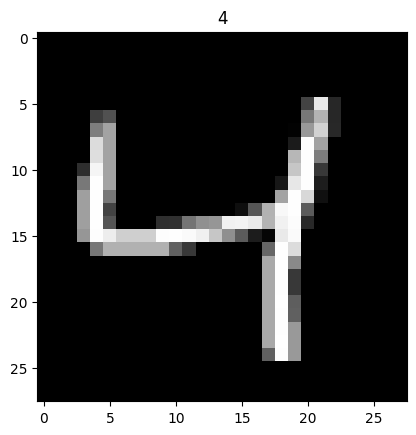

In [25]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [26]:
import multiprocessing

num_cores = multiprocessing.cpu_count()


# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers= 6, shuffle=True)


data = next(iter(train_loader))
print(data[0].size())

torch.Size([256, 1, 28, 28])


In [27]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 12),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [28]:
autoencoder = AutoEncoder().to(device)
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Epoch:  0 | train loss: 0.2326


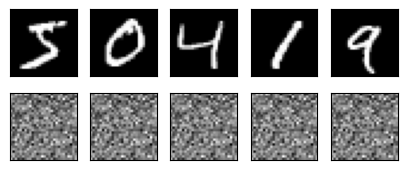

Epoch:  5 | train loss: 0.0611


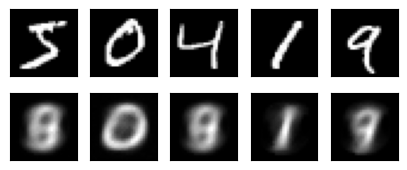

Epoch:  10 | train loss: 0.0509


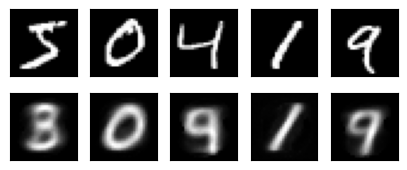

Epoch:  15 | train loss: 0.0432


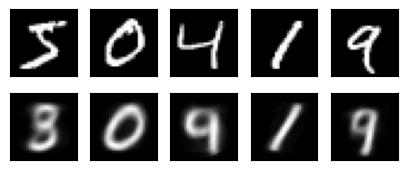

Epoch:  20 | train loss: 0.0398


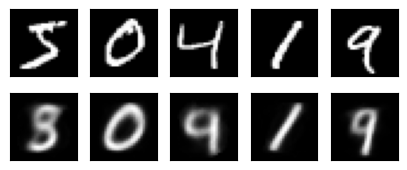

Epoch:  25 | train loss: 0.0390


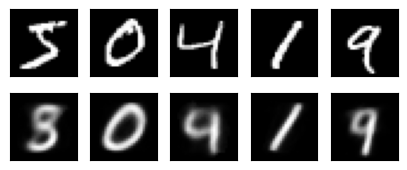

Epoch:  49 | train loss: 0.0278


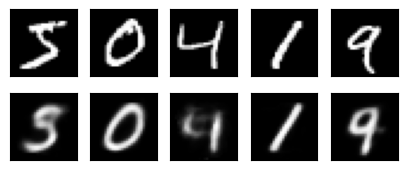

In [30]:

autoencoder = AutoEncoder().to(device)
autoencoder.to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()


# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.).to(device)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x     = x.view(-1, 28*28).to(device)   # batch x, shape (batch, 28*28)
        b_y     = x.view(-1, 28*28).to(device)   # batch y, shape (batch, 28*28)
        b_label = y.to(device)                   # batch label

        autoencoder.train()
        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5,10,15,20,25, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())

            # plotting decoded image (second row)
            autoencoder.eval()
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)
            

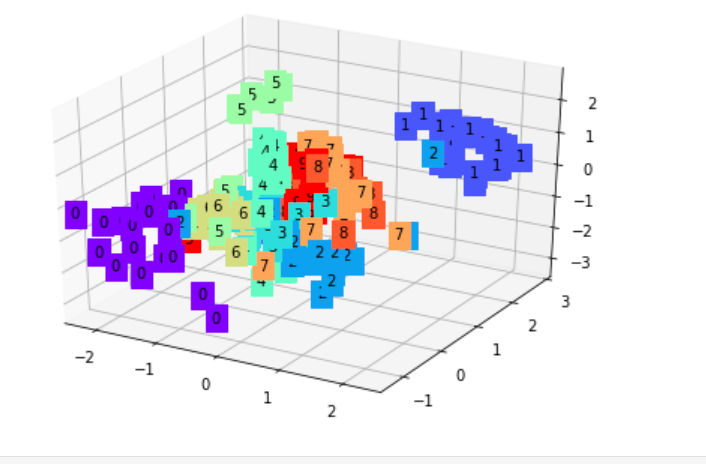